## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

### Motivation
### Process
1. select level and patch size, label each patch \
  save labeled patch as training dataset \
2. transfer learning with fine tuning 
3. locating (visualize model predcition as heatmap)


In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (149 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
# Download an example slide and tumor mask

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, slide.level_dimensions[0][0], slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, slide.level_dimensions[i], slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

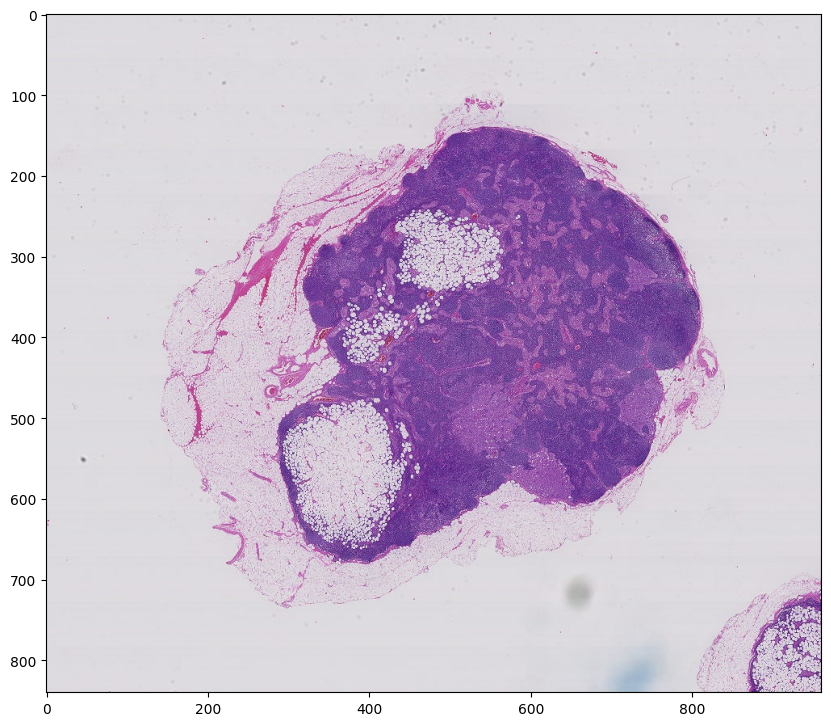

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=6, 
                         width=slide.level_dimensions[6][0], 
                         height=slide.level_dimensions[6][1]#,
                         #width=800, 
                         #height=800
                         )

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

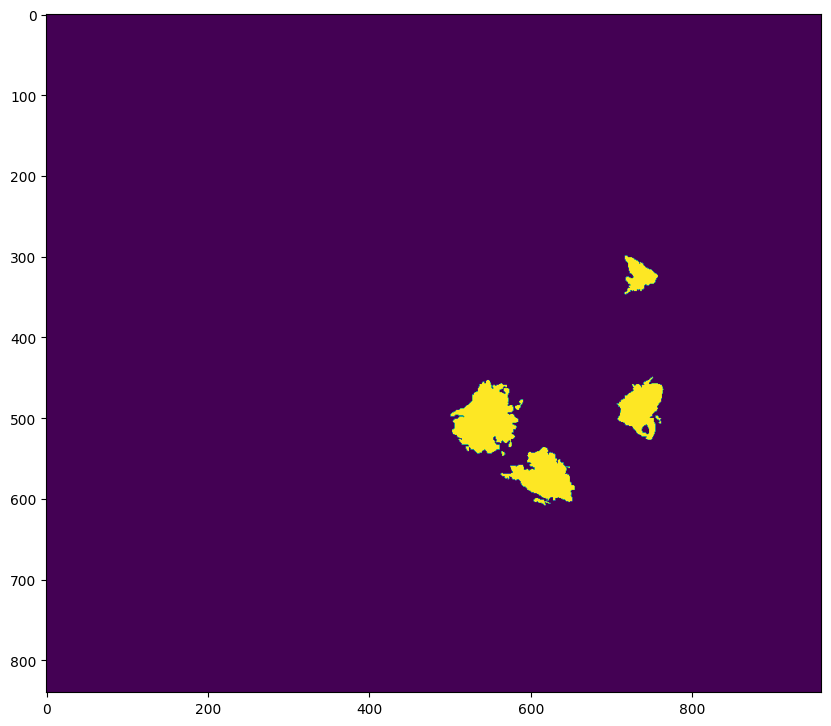

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=6, 
                        width=slide.level_dimensions[6][0], 
                        height=slide.level_dimensions[6][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

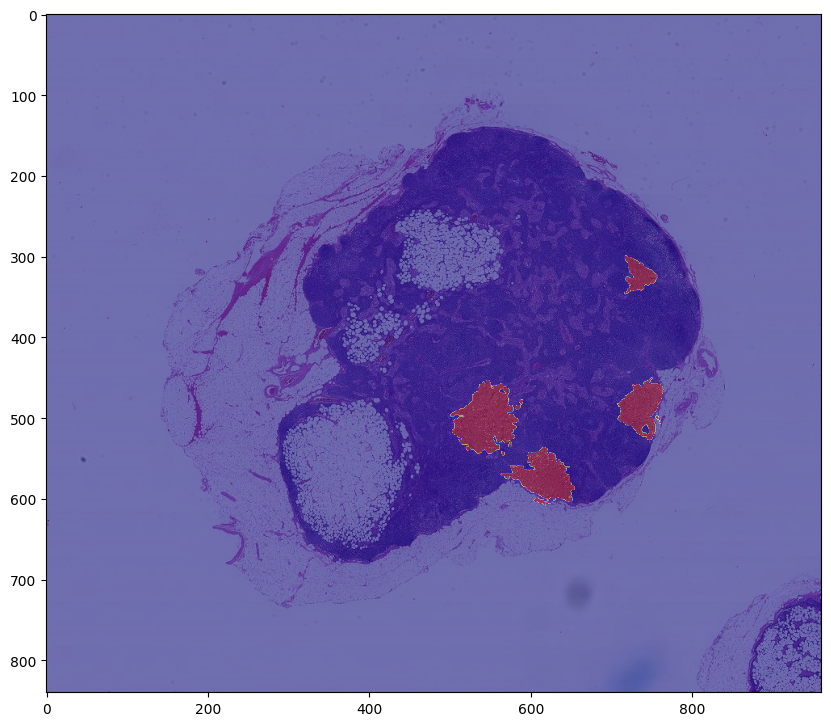

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

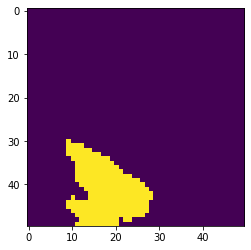

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

237731 tissue_pixels pixels (33.7 percent of the image)


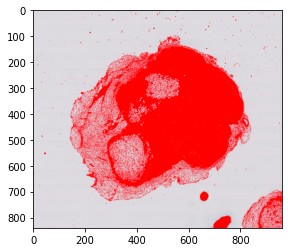

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)

plt.imshow(tissue_regions)

### Define Patch & Construct Training Data
1. remove gray (slice and mask) 
2. create patch to seperate image (general) - patch size = 200 * 200
2. save patch with corresponding labels (general) 


In [ ]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url


In [ ]:
os.chdir('/content')

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, slide.level_dimensions[0][0], slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif


In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where((im_gray <= intensity) & (im_gray > 0))
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

237731 tissue_pixels pixels (33.7 percent of the image)


In [ ]:
slide_image = read_slide(slide, x=0, y=0, level=6, width=slide.level_dimensions[6][0], height=slide.level_dimensions[6][1])
print(slide_image.shape)

mask_image = read_slide(tumor_mask, x=0, y=0, level=6, width=slide.level_dimensions[6][0], height=slide.level_dimensions[6][1])

(840, 960, 3)


In [ ]:
def create_patch(slice, level, p_size, is_mask=False, padding=True):
  img_x, img_y = slice.level_dimensions[level]
  down_sample_level = int(slice.level_downsamples[level])
  patch_list = []
  for y in range(int(np.floor(img_y / p_size))):
    for x in range(int(np.floor(img_x / p_size))):
      img = read_slide(slice, x * p_size * down_sample_level, y * p_size * down_sample_level, level, p_size, p_size)
      if is_mask:
        patch_list.append(img[:,:,0])
      else:
        patch_list.append(img)
  return patch_list

In [ ]:
slice_patches = create_patch(slide, 5, 200)
mask_patches = create_patch(tumor_mask, 5, 200, is_mask=True)

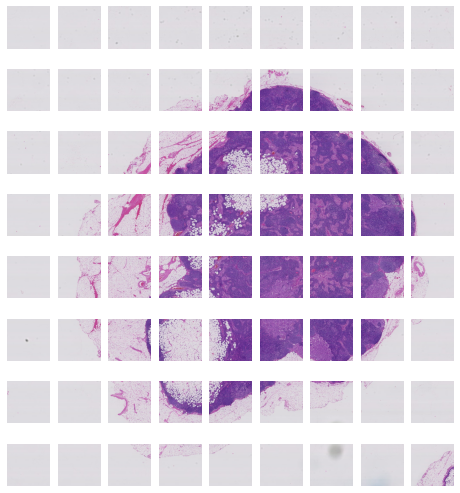

In [ ]:
plt.figure(figsize=(8, 9))
for i in range(len(slice_patches)):
  img = slice_patches[i]
  ax = plt.subplot(8, 9, i + 1)
  plt.imshow(img)
  plt.axis("off")

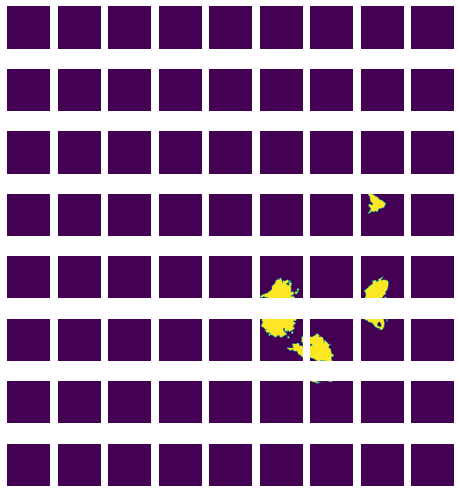

In [ ]:
plt.figure(figsize=(8, 9))
for i in range(len(mask_patches)):
  img = mask_patches[i]
  ax = plt.subplot(8, 9, i + 1)
  plt.imshow(img)
  plt.axis("off")

### Save patch (level 2 - 4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from PIL import Image

Mounted at /content/drive


In [ ]:
def remove_gray_patch(slice_patch, intensity=0.8, threshold=0.2):
  reserve_index = []
  for i in range(len(slice_patch)):
    slice_img = slice_patch[i]
    tissue_pixels = find_tissue_pixels(slice_img, intensity)
    percent_tissue = len(tissue_pixels) / float(slice_img.shape[0] * slice_img.shape[0])
    if percent_tissue > threshold:
      reserve_index.append(i)

  return reserve_index

In [ ]:
def update_patch(patches, reserve_idx):
  updated = [patches[i] for i in reserve_idx]
  return updated

In [ ]:
def split_patch(mask_patch, slice_idx):
  normal_list = []
  tumor_list = []

  for i in slice_idx:
    mask_patch_i = mask_patch[i]
    if np.sum(mask_patch_i) == 0:
      normal_list.append(i)
    else:
      tumor_list.append(i)

  return normal_list, tumor_list

In [ ]:
os.chdir('/content')
PATCH_SIZE = 224

# patch for level 2-4
slice_patches_4 = create_patch(slide, 4, PATCH_SIZE)
mask_patches_4 = create_patch(tumor_mask, 4, PATCH_SIZE, is_mask=True)
slice_patches_3 = create_patch(slide, 3, PATCH_SIZE)
mask_patches_3 = create_patch(tumor_mask, 3, PATCH_SIZE, is_mask=True)
slice_patches_2 = create_patch(slide, 2, PATCH_SIZE)
mask_patches_2 = create_patch(tumor_mask, 2, PATCH_SIZE, is_mask=True)

# remove gray patch level 4
slice_idx_4 = remove_gray_patch(slice_patches_4, threshold=0.05)

In [ ]:
#int(np.ceil(slide.level_dimensions[3][0] / 224))
level4_row_size = int(np.floor(slide.level_dimensions[4][0] / PATCH_SIZE))
level3_row_size = int(np.floor(slide.level_dimensions[3][0] / PATCH_SIZE))
level2_row_size = int(np.floor(slide.level_dimensions[2][0] / PATCH_SIZE))

slice_idx_3 = []
slice_idx_2 = []

for i in slice_idx_4:
  rownum = int(np.floor(i / level4_row_size))
  slice_idx_3 += [i*2+level3_row_size*rownum, i*2+level3_row_size*rownum+1, 
                  i*2+level3_row_size*(rownum+1), i*2+level3_row_size*(rownum+1)+1]

for i in slice_idx_3:
  rownum = int(np.floor(i / level3_row_size))
  slice_idx_2 += [i*2+level2_row_size*rownum, i*2+level2_row_size*rownum+1, 
                  i*2+level2_row_size*(rownum+1), i*2+level2_row_size*(rownum+1)+1]

In [ ]:

# update patches and split level 2-4

# slice_patches_update_4 = update_patch(slice_patches_4, slice_idx_4)
# mask_patches_update_4 = update_patch(mask_patches_4, slice_idx_4)

# slice_patches_update_3 = update_patch(slice_patches_3, slice_idx_3)
# mask_patches_update_3 = update_patch(mask_patches_3, slice_idx_3)

# slice_patches_update_2 = update_patch(slice_patches_2, slice_idx_2)
# mask_patches_update_2 = update_patch(mask_patches_2, slice_idx_2)

# normal_list_4, tumor_list_4 = split_patch(slice_patches_update_4, mask_patches_update_4)
# normal_list_3, tumor_list_3 = split_patch(slice_patches_update_3, mask_patches_update_3)
# normal_list_2, tumor_list_2 = split_patch(slice_patches_update_2, mask_patches_update_2)

In [ ]:
normal_list_2, tumor_list_2 = split_patch(mask_patches_2, slice_idx_2)

In [ ]:
normal_list_3 = []
tumor_list_3 = []

for i in normal_list_2:
  current_row = int(np.floor(i/level2_row_size))
  if current_row % 2 == 1:
    i = i - level2_row_size
  rownum = int(np.floor(i / level2_row_size))/2
  normal_list_3.append(int(np.floor((i-level2_row_size*rownum)/2)))

for i in tumor_list_2:
  current_row = int(np.floor(i/level2_row_size))
  if current_row % 2 == 1:
    i = i - level2_row_size
  rownum = int(np.floor(i / level2_row_size))/2
  tumor_list_3.append(int(np.floor((i-level2_row_size*rownum)/2)))

In [ ]:
normal_list_4 = []
tumor_list_4 = []

for i in normal_list_3:
  current_row = int(np.floor(i/level3_row_size))
  if current_row % 2 == 1:
    i = i - level3_row_size
  rownum = int(np.floor(i / level3_row_size))/2
  normal_list_4.append(int(np.floor((i-level3_row_size*rownum)/2)))

for i in tumor_list_3:
  current_row = int(np.floor(i/level3_row_size))
  if current_row % 2 == 1:
    i = i - level3_row_size
  rownum = int(np.floor(i / level3_row_size))/2
  tumor_list_4.append(int(np.floor((i-level3_row_size*rownum)/2)))

In [ ]:
normal_slice_2 = update_patch(slice_patches_2, normal_list_2)
tumor_slice_2 = update_patch(slice_patches_2, tumor_list_2)

normal_slice_3 = update_patch(slice_patches_3, normal_list_3)
tumor_slice_3 = update_patch(slice_patches_3, tumor_list_3)

normal_slice_4 = update_patch(slice_patches_4, normal_list_4)
tumor_slice_4 = update_patch(slice_patches_4, tumor_list_4)

In [ ]:
def save_patches(normal_slice, tumor_slice, level, name_factor=0):
  #os.chdir('/content')
  print(f"normal list size: {len(normal_slice)}, tumor list size: {len(tumor_slice)}")

  pathnormal = os.path.join("/content/drive/MyDrive/TumorImage/normal","level" + str(level))
  pathtumor = os.path.join("/content/drive/MyDrive/TumorImage/tumor","level" + str(level))

  os.chdir(pathnormal)
  for i, img in enumerate(normal_slice):
    newImage = Image.fromarray(img)
    newImage.save("normal" + str(i + name_factor) + ".png")

  os.chdir(pathtumor)
  for i, img in enumerate(tumor_slice):
    newImage = Image.fromarray(img)
    newImage.save("tumor" + str(i + name_factor) + ".png")

In [ ]:
save_patches(normal_slice_2, tumor_slice_2, 2)
save_patches(normal_slice_3, tumor_slice_3, 3)
save_patches(normal_slice_4, tumor_slice_4, 4)

normal list size: 1761, tumor list size: 111
normal list size: 1761, tumor list size: 111
normal list size: 1761, tumor list size: 111


### Add another slice to training dataset

In [ ]:

slide_path2 = '/content/drive/MyDrive/tumor_101.tif' # only this file is available
tumor_mask_path2 = '/content/drive/MyDrive/tumor_101_mask.tif' # only this file is available

# slide_url2 = 'https://drive.google.com/drive/folders/1qY1Jjo3kUQ9QV6npOKvVuwx-RC3V4akY?usp=sharing' % slide_path2
# mask_url2 = 'https://drive.google.com/drive/folders/1qY1Jjo3kUQ9QV6npOKvVuwx-RC3V4akY?usp=sharing' % tumor_mask_path2

# # Download the whole slide image
# if not os.path.exists(slide_path2):
#   !curl -O $slide_url2

# # Download the tumor mask
# if not os.path.exists(tumor_mask_path2):
#   !curl -O $mask_url2

In [ ]:
tumor_mask2 = open_slide(tumor_mask_path2)
slide2 = open_slide(slide_path2)
print(tumor_mask2.level_dimensions)
print(tumor_mask2.level_downsamples)

((139264, 71680), (69632, 35840), (34816, 17920), (17408, 8960), (8704, 4480), (4352, 2240), (2176, 1120), (1088, 560), (544, 280))
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)


In [ ]:
os.chdir('/content')
PATCH_SIZE = 224

# patch for level 2-4
slice2_patches_4 = create_patch(slide2, 4, PATCH_SIZE)
mask2_patches_4 = create_patch(tumor_mask2, 4, PATCH_SIZE, is_mask=True)
slice2_patches_3 = create_patch(slide2, 3, PATCH_SIZE)
mask2_patches_3 = create_patch(tumor_mask2, 3, PATCH_SIZE, is_mask=True)
slice2_patches_2 = create_patch(slide2, 2, PATCH_SIZE)
mask2_patches_2 = create_patch(tumor_mask2, 2, PATCH_SIZE, is_mask=True)

# remove gray patch level 4
slice2_idx_4 = remove_gray_patch(slice2_patches_4, threshold=0.05)

In [ ]:
# discard margins on level 2, 3 to match with level 4 patches
reserve_idx_3 = []
for i in range(len(slice2_patches_3)):
  if (i + 1) % 77 != 0:
    reserve_idx_3.append(i)

reserve_idx_2 = []
for i in range(len(slice2_patches_2)):
  if ((i+1)%155 != 0) and ((i+2)%155 != 0) and ((i+3)%155 != 0):
    reserve_idx_2.append(i)

In [ ]:
# update patch lv3, 2
slice2_patches_3 = update_patch(slice2_patches_3, reserve_idx_3)
mask2_patches_3 = update_patch(mask2_patches_3, reserve_idx_3)

slice2_patches_2 = update_patch(slice2_patches_2, reserve_idx_2)
mask2_patches_2 = update_patch(mask2_patches_2, reserve_idx_2)

In [ ]:
level4_row_size = int(np.floor(slide2.level_dimensions[4][0] / PATCH_SIZE))
level3_row_size = int(np.floor(slide2.level_dimensions[3][0] / PATCH_SIZE)) - 1
level2_row_size = int(np.floor(slide2.level_dimensions[2][0] / PATCH_SIZE)) - 3

slice2_idx_3 = []
slice2_idx_2 = []

for i in slice2_idx_4:
  rownum = int(np.floor(i / level4_row_size))
  slice2_idx_3 += [i*2+level3_row_size*rownum, i*2+level3_row_size*rownum+1, 
                  i*2+level3_row_size*(rownum+1), i*2+level3_row_size*(rownum+1)+1]

for i in slice2_idx_3:
  rownum = int(np.floor(i / level3_row_size))
  slice2_idx_2 += [i*2+level2_row_size*rownum, i*2+level2_row_size*rownum+1, 
                  i*2+level2_row_size*(rownum+1), i*2+level2_row_size*(rownum+1)+1]

In [ ]:
normal_list_2, tumor_list_2 = split_patch(mask2_patches_2, slice2_idx_2)

In [ ]:
normal_list_3 = []
tumor_list_3 = []

for i in normal_list_2:
  current_row = int(np.floor(i/level2_row_size))
  if current_row % 2 == 1:
    i = i - level2_row_size
  rownum = int(np.floor(i / level2_row_size))/2
  normal_list_3.append(int(np.floor((i-level2_row_size*rownum)/2)))

for i in tumor_list_2:
  current_row = int(np.floor(i/level2_row_size))
  if current_row % 2 == 1:
    i = i - level2_row_size
  rownum = int(np.floor(i / level2_row_size))/2
  tumor_list_3.append(int(np.floor((i-level2_row_size*rownum)/2)))

In [ ]:
normal_list_4 = []
tumor_list_4 = []

for i in normal_list_3:
  current_row = int(np.floor(i/level3_row_size))
  if current_row % 2 == 1:
    i = i - level3_row_size
  rownum = int(np.floor(i / level3_row_size))/2
  normal_list_4.append(int(np.floor((i-level3_row_size*rownum)/2)))

for i in tumor_list_3:
  current_row = int(np.floor(i/level3_row_size))
  if current_row % 2 == 1:
    i = i - level3_row_size
  rownum = int(np.floor(i / level3_row_size))/2
  tumor_list_4.append(int(np.floor((i-level3_row_size*rownum)/2)))

In [ ]:
normal_slice2_2 = update_patch(slice2_patches_2, normal_list_2)
tumor_slice2_2 = update_patch(slice2_patches_2, tumor_list_2)

normal_slice2_3 = update_patch(slice2_patches_3, normal_list_3)
tumor_slice2_3 = update_patch(slice2_patches_3, tumor_list_3)

normal_slice2_4 = update_patch(slice2_patches_4, normal_list_4)
tumor_slice2_4 = update_patch(slice2_patches_4, tumor_list_4)

In [ ]:
save_patches(normal_slice2_2, tumor_slice2_2, 2, 1872)
save_patches(normal_slice2_3, tumor_slice2_3, 3, 1872)
save_patches(normal_slice2_4, tumor_slice2_4, 4, 1872)

normal list size: 4544, tumor list size: 352
normal list size: 4544, tumor list size: 352
normal list size: 4544, tumor list size: 352


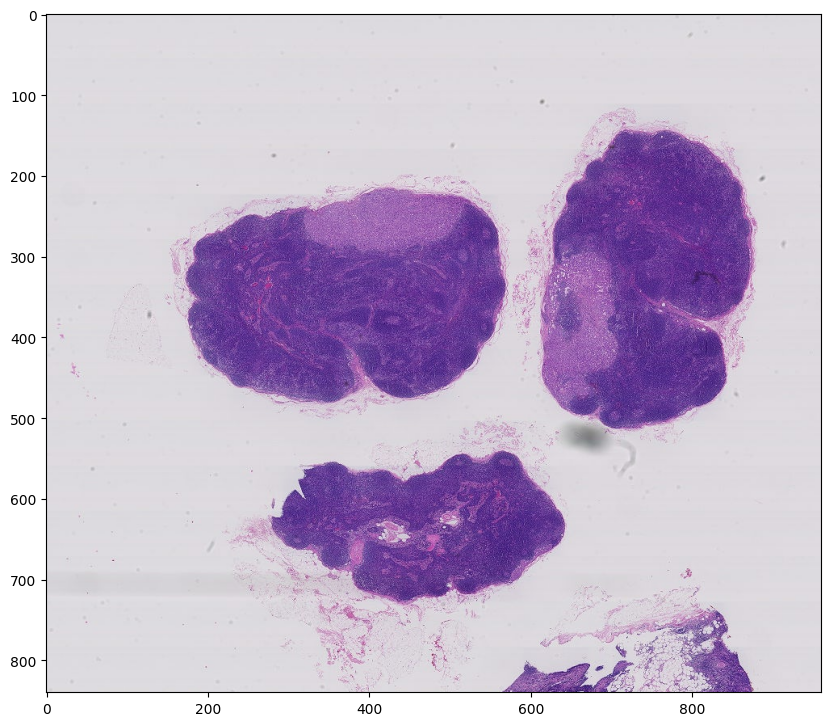

In [ ]:
slide_image2 = read_slide(slide2, 
                         x=0, 
                         y=0, 
                         level=6, 
                         width=slide.level_dimensions[6][0], 
                         height=slide.level_dimensions[6][1]#,
                         #width=800, 
                         #height=800
                         )

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image2)

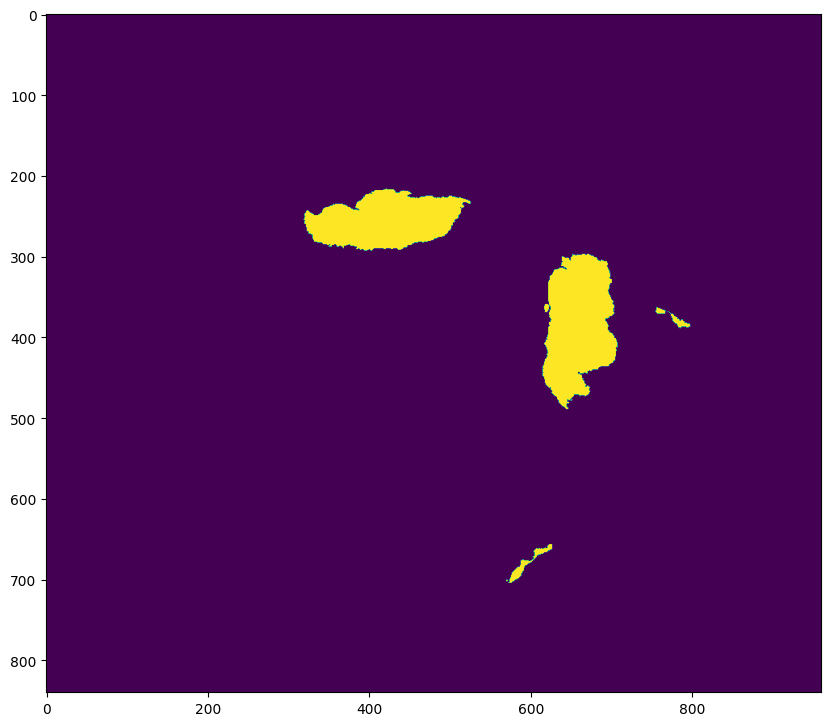

In [ ]:
mask_image2 = read_slide(tumor_mask2, 
                         x=0, 
                         y=0, 
                         level=6, 
                         width=slide.level_dimensions[6][0], 
                         height=slide.level_dimensions[6][1]#,
                         #width=800, 
                         #height=800
                         )
mask_image2 = mask_image2[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image2)